In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [7]:
raw_df = pd.read_csv('./data/CC_GENERAL.csv')
raw_df = raw_df.drop('CUST_ID', axis = 1) 
raw_df.fillna(method ='ffill', inplace = True) 
raw_df.head(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [8]:
raw_df.shape

(8950, 17)

In [32]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# Normalizing the Data
normalized_df = normalize(scaled_df)
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df)

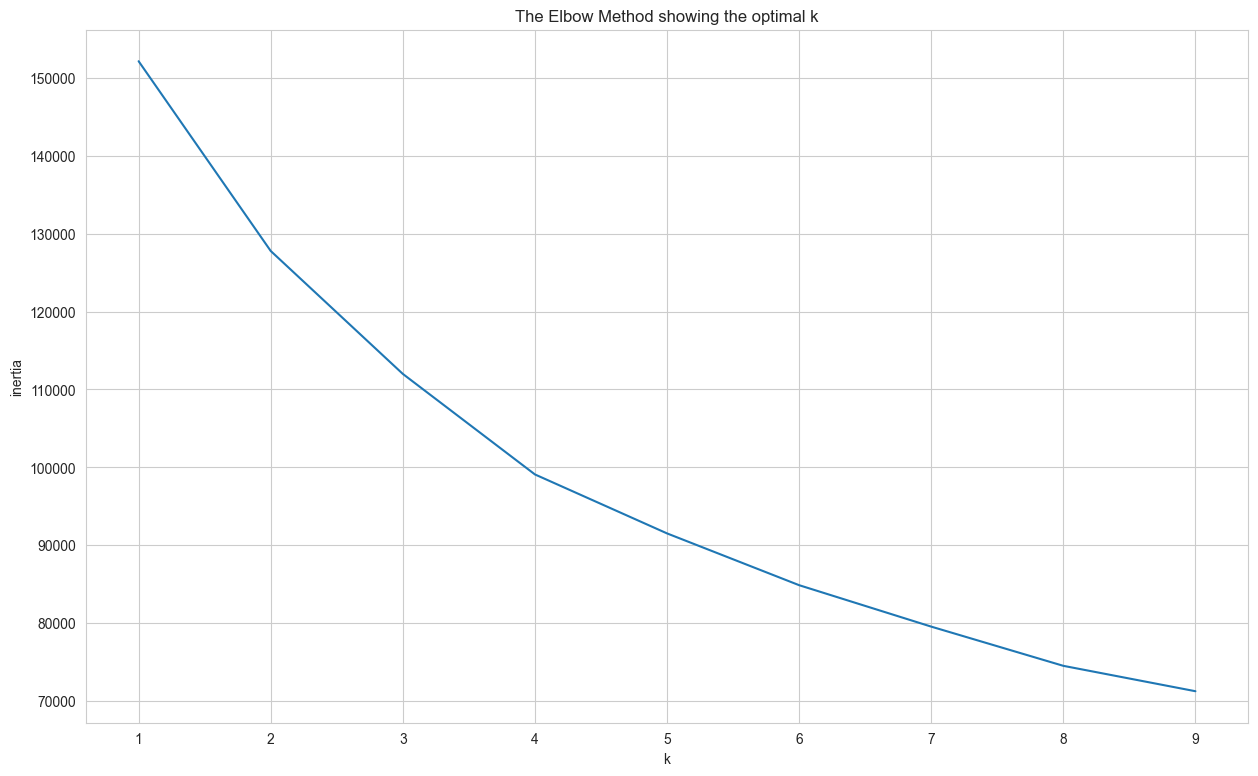

In [31]:
inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(normalized_df)
    inertia.append(km.inertia_)

plt.figure(figsize=(15, 9))
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k');

In [11]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
distance_mat = pdist(normalized_df) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма

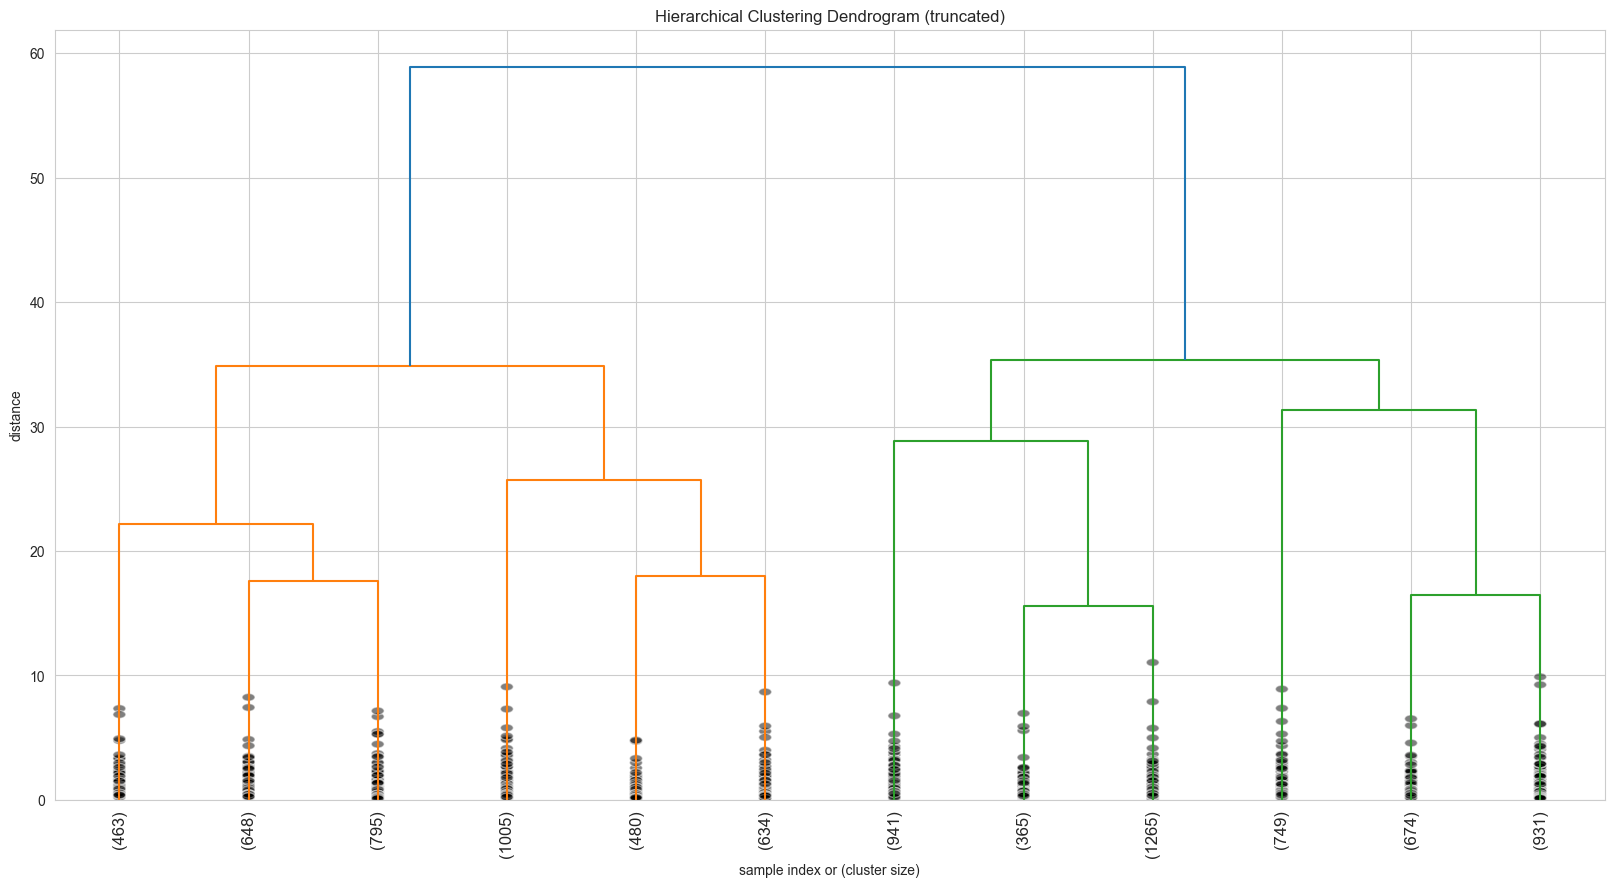

In [12]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

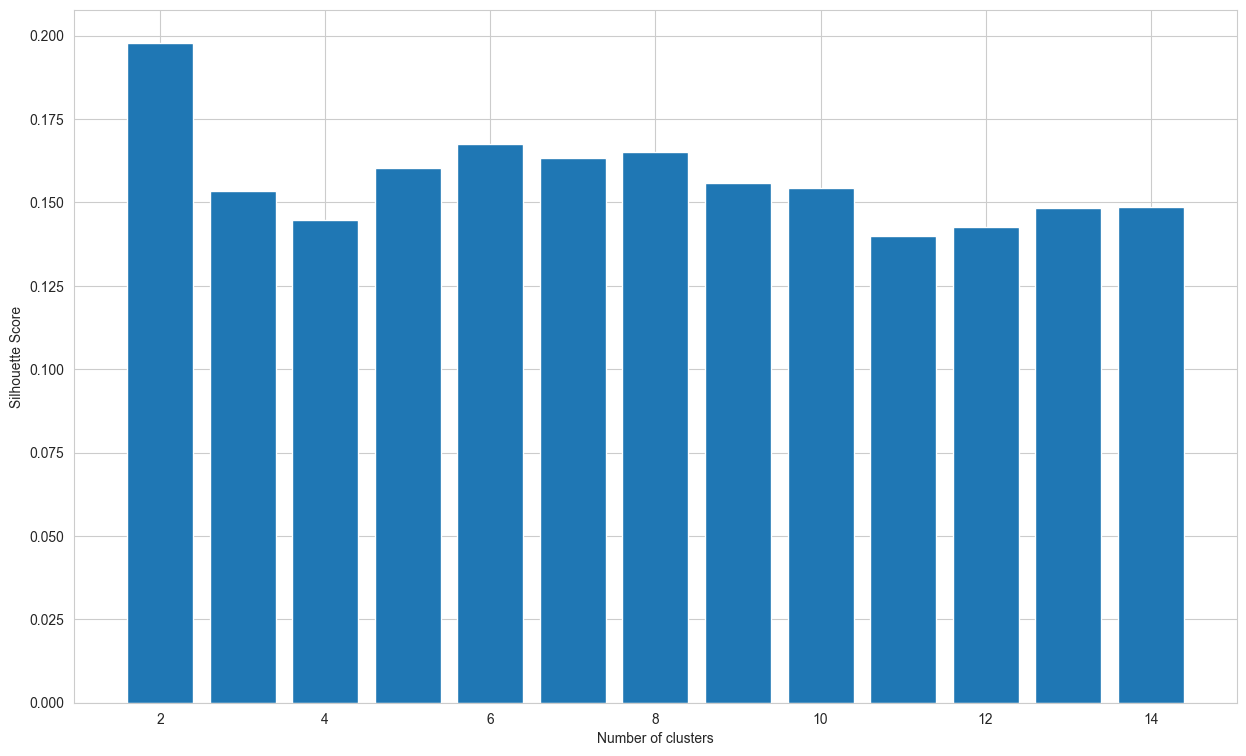

In [13]:
silhouette_scores = [] 

for n_cluster in range(2, 15):
    silhouette_scores.append( 
        silhouette_score(normalized_df, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(normalized_df))) 
    
    
# Plotting a bar graph to compare the results 
k = [i for i in range(2,15)]
plt.figure(figsize=(15, 9))
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [14]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.45).fit(normalized_df)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/normalized_df.shape[0]))

Estimated number of clusters: 2
Estimated percentage of noise points: 5.41%


In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=45)

tsne_transformed = tsne.fit_transform(normalized_df)

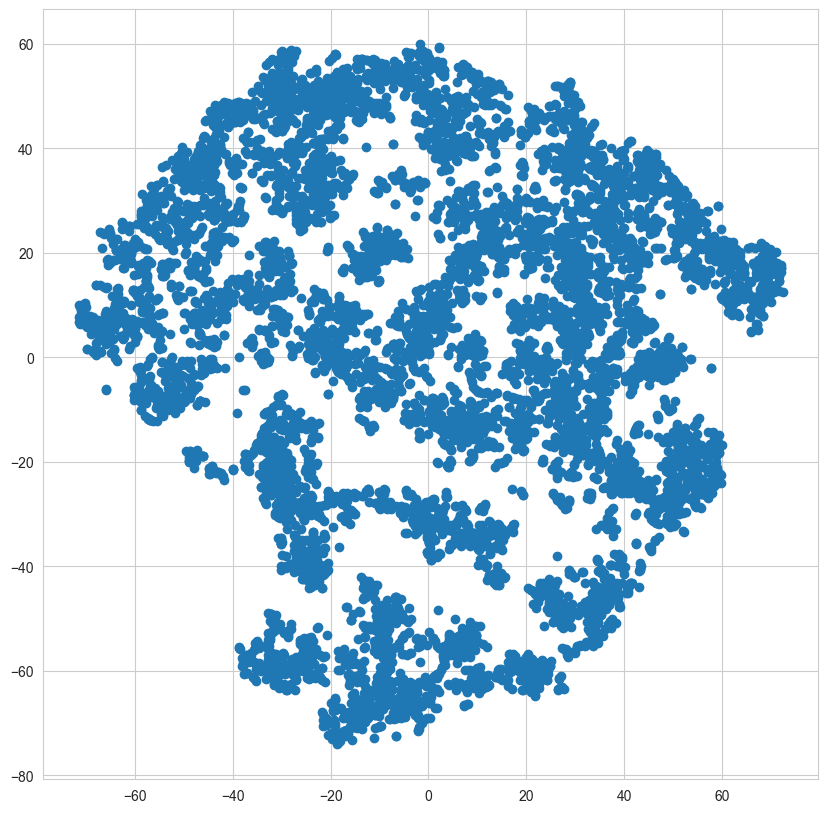

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1]);

In [25]:
km = KMeans(n_clusters=6).fit(normalized_df)

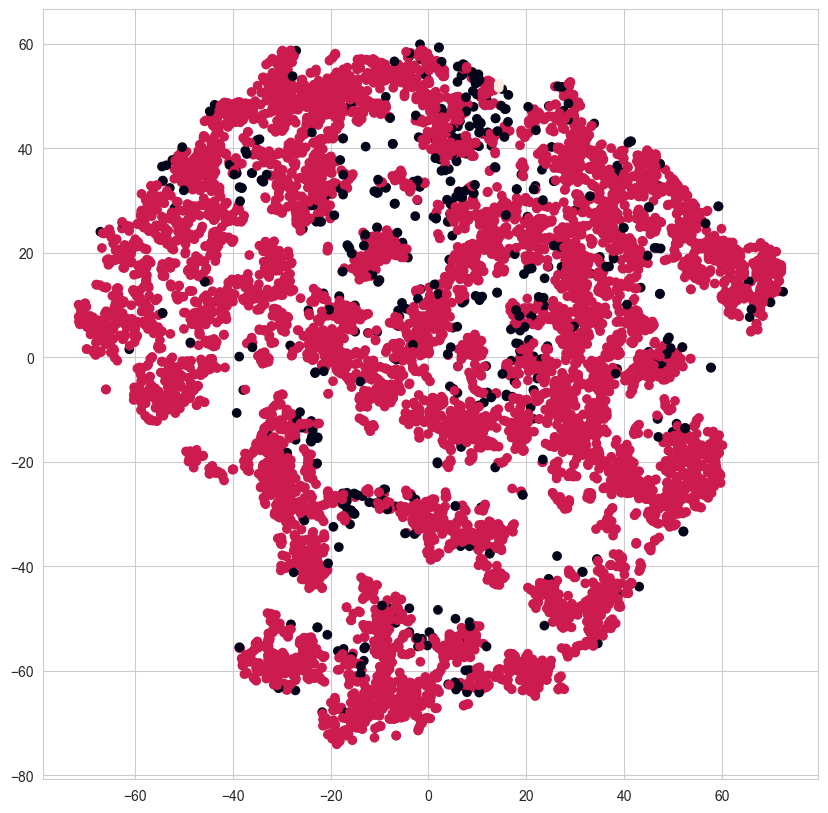

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=db.labels_);

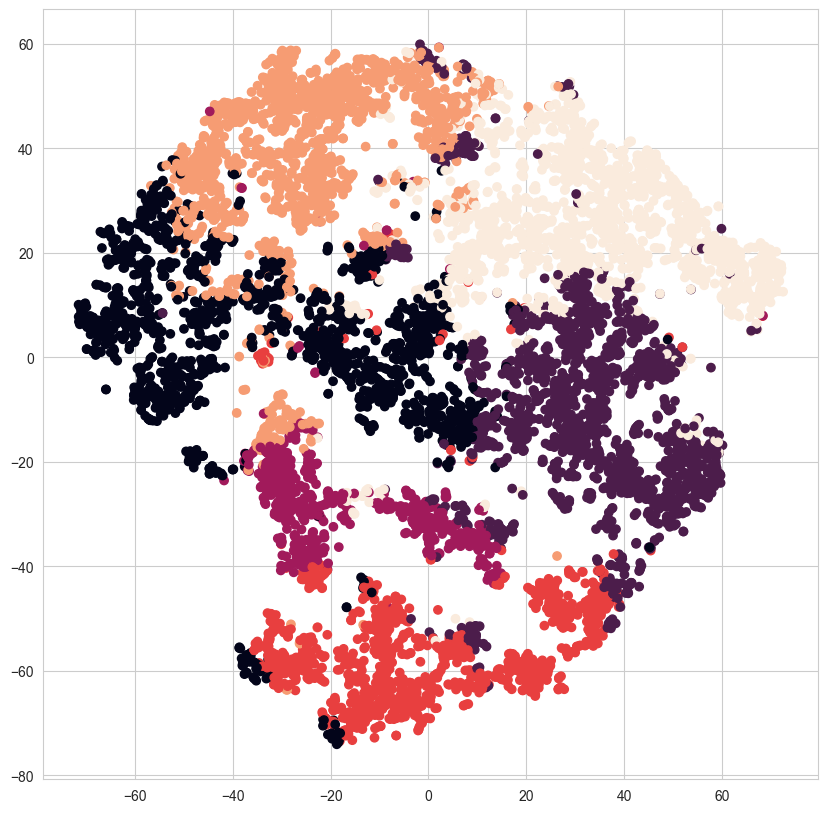

In [27]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=km.labels_);

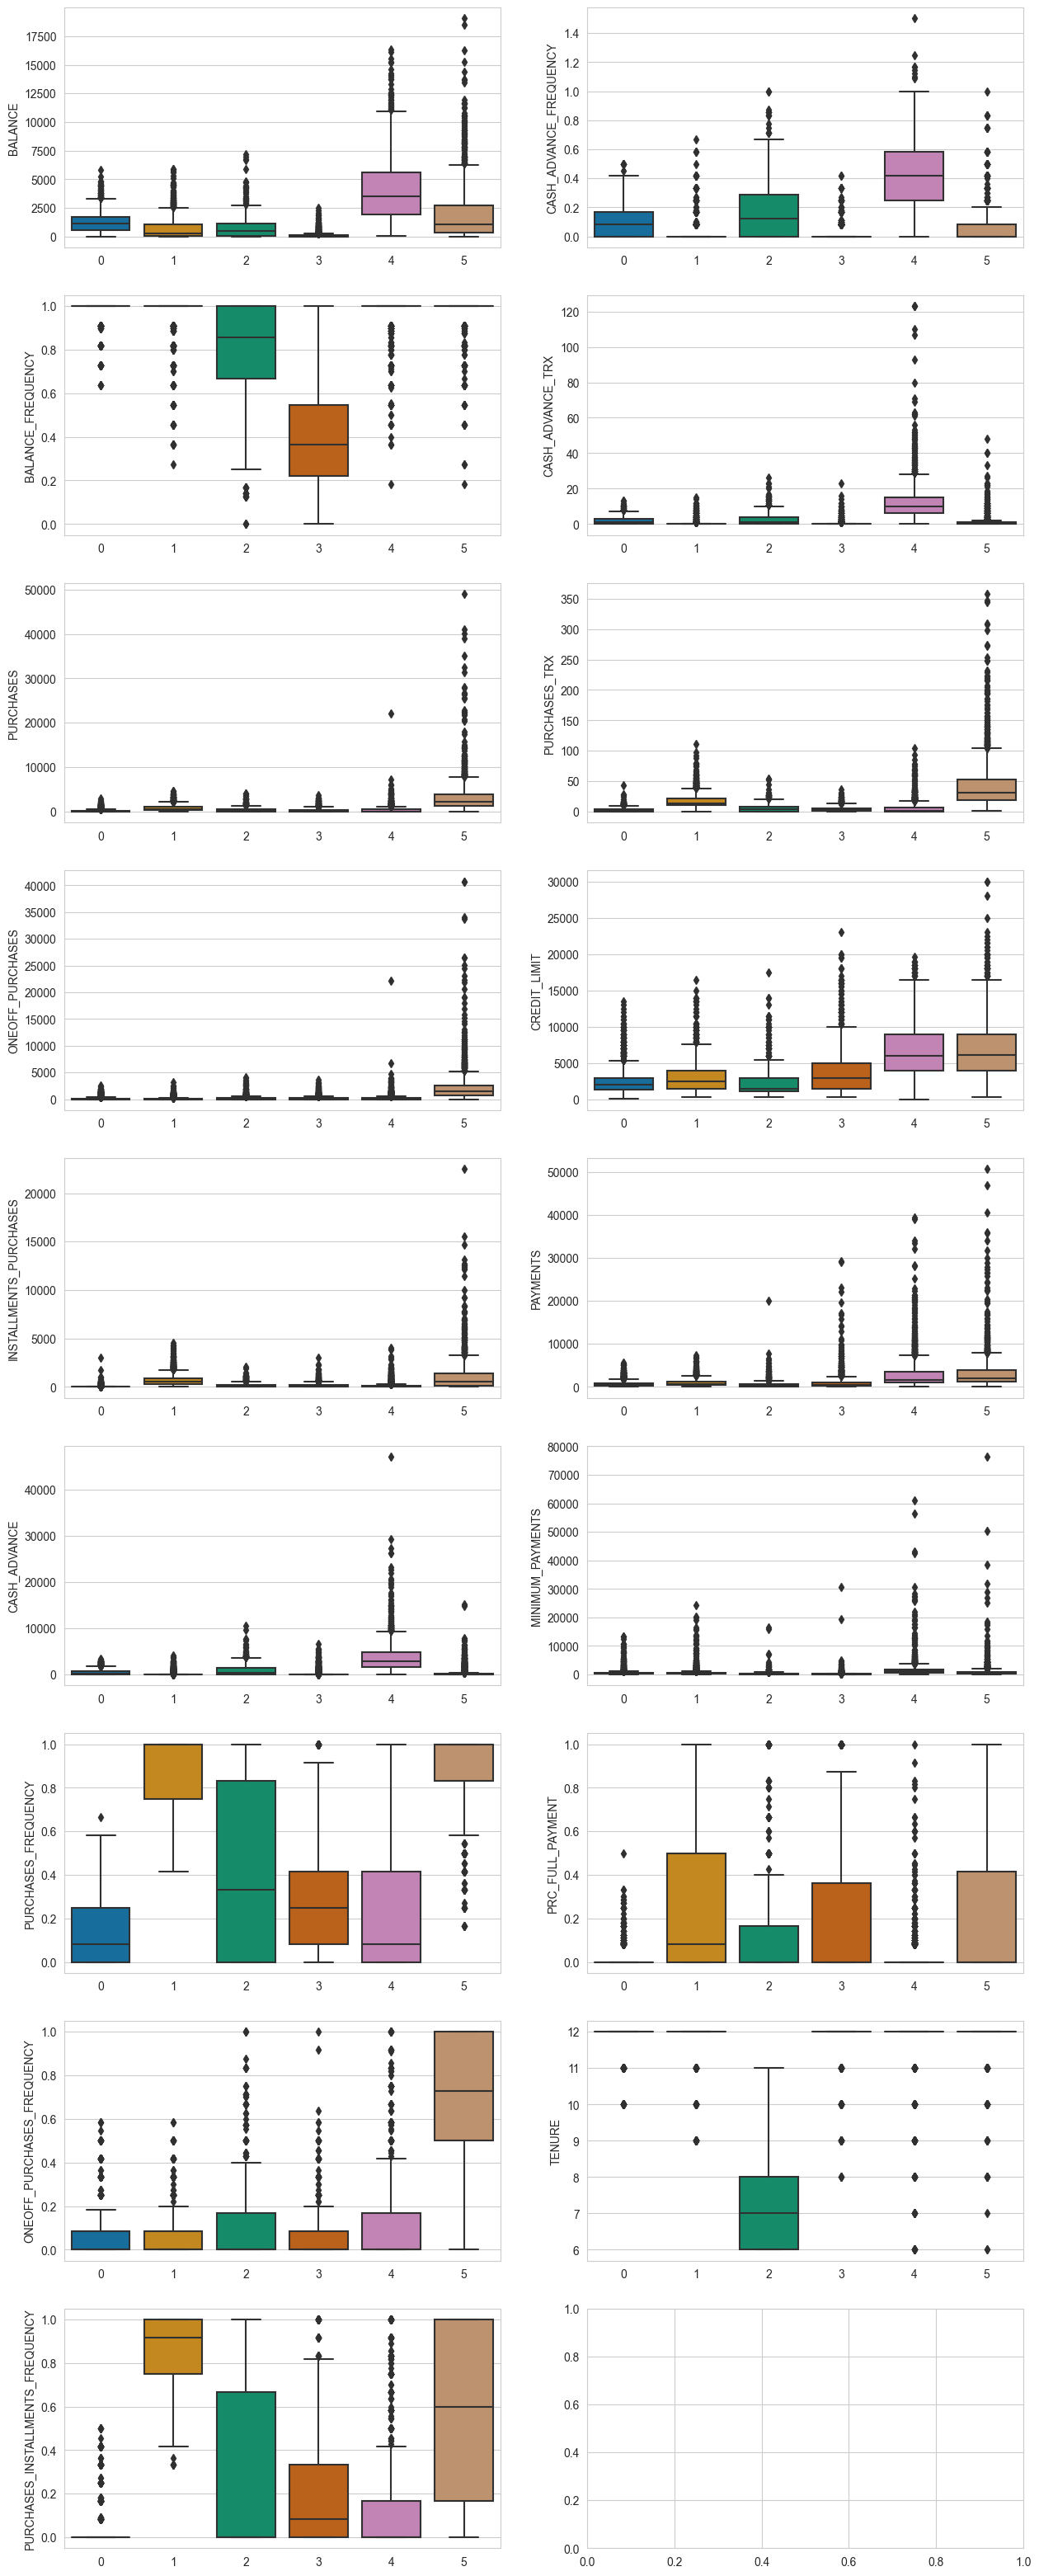

In [29]:
import seaborn as sns
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(15, 40))

i_col = 0
i_row = 0

for column in raw_df.columns:
    sns.boxplot(y=column, x=km.labels_, 
                     data=raw_df, 
                     palette="colorblind", ax=ax[i_row, i_col])
    if i_row < 8:
        i_row += 1
    else:
        i_col += 1
        i_row = 0